<a href="https://colab.research.google.com/github/Saarle/Regression-Project/blob/main/Regression_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Regression Project - Salary Prediction**





In [10]:
#import all the necessary libraries

import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
import warnings
import seaborn as sns
import re

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor , plot_tree

from feature_engine.encoding import CountFrequencyEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')
%matplotlib inline

# create a function to read csv file directly from google drive

def csv_drive_path_generatoer(url):
 '''
 Help in read csv file directly from google drive.
 Make sure the csv format is standard.
 url:str - path to csv file example:
   url = 'https://drive.google.com/file/d/126JPZ3lYwdLyJ2d_7jxM9jMtZaOlF-Ld/view?usp=sharing'
 return : str
 '''
 path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
 return path

In [11]:
# read the data
path = csv_drive_path_generatoer('https://drive.google.com/file/d/1R3vBFIn6YPrgpvyAADCY0yAYthaGy9NF/view?usp=sharing')
path_y = csv_drive_path_generatoer('https://drive.google.com/file/d/10wLZgOF00TY5Kmg0d_rn_agoEAFMVbwB/view?usp=sharing')
path_X_test = csv_drive_path_generatoer('https://drive.google.com/file/d/1Q_W-3CE0RppRIrfl_epEGnhJEQlfRb-5/view?usp=drive_link')
X = pd.read_csv(path)
y=  pd.read_csv(path_y)
X_test_pred = pd.read_csv(path_X_test)


In [12]:
# order the columns 
X.rename(columns = {"Unnamed: 0.1": "Id1",
                    "Unnamed: 0": "Id2",
                    "Education Level":"Education_Level",
                    "Job Title": "Job_Title",
                   "Years of Experience": "Years_of_Experience"},
                    inplace=True)

column_order =['id','Id1','Id2','Age','Gender','Education_Level','Job_Title','Years_of_Experience','Country','Race','height','weight','professionalism']
X = X[column_order]

In [13]:
# check and drop duplicated columns 

def drop_duplicate_columns(data):
    columns_to_keep = data.T[~data.T.duplicated()].index

    return data[columns_to_keep]



In [14]:
class DataPreprocessor:
    def __init__(self, data):
        self.data = data
    
    def rename_and_reorder_columns(self):
        # Rename columns
        self.data.rename(columns={
            "Unnamed: 0.1": "Id1",
            "Unnamed: 0": "Id2",
            "Education Level": "Education_Level",
            "Job Title": "Job_Title",
            "Years of Experience": "Years_of_Experience"
        }, inplace=True)
        
        # Reorder columns
        column_order = ['id', 'Id1', 'Id2', 'Age', 'Gender', 'Education_Level', 'Job_Title', 'Years_of_Experience', 'Country', 'Race', 'height', 'weight', 'professionalism']
        self.data = self.data[column_order]

    def drop_duplicate_columns(self):
        columns_to_keep = self.T[~self.T.duplicated()].index

        self.data = data[columns_to_keep]



# Assuming X is your DataFrame
preprocessor = DataPreprocessor(X_test_pred)
preprocessor.rename_and_reorder_columns()
# preprocessor.drop_duplicate_columns()

# Access the modified data
modified_X = preprocessor.data

In [15]:
modified_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341 entries, 0 to 1340
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1341 non-null   int64  
 1   Id1                  1341 non-null   int64  
 2   Id2                  1341 non-null   int64  
 3   Age                  1341 non-null   float64
 4   Gender               1341 non-null   object 
 5   Education_Level      1341 non-null   object 
 6   Job_Title            1341 non-null   object 
 7   Years_of_Experience  1341 non-null   float64
 8   Country              1341 non-null   object 
 9   Race                 1341 non-null   object 
 10  height               1341 non-null   float64
 11  weight               1341 non-null   float64
 12  professionalism      1341 non-null   float64
dtypes: float64(5), int64(3), object(5)
memory usage: 136.3+ KB


# **EDA and Data Cleaning**


In [16]:
# set id as index
data = X.join(y)
data.sort_values(by='id')

,id,Id1,Id2,Age,Gender,Education_Level,Job_Title,Years_of_Experience,Country,Race,height,weight,professionalism,Unnamed: 0,Salary
417,0,0,0,NaN,NaN,bachelor,software|enginee,120.0,RazShmuelykingdom,NayaCollegegeek,2.492683,200.000000,160.0,0,90000.0
2839,1,1,1,NaN,NaN,master,data|analys,120.0,RazShmuelykingdom,NayaCollegegeek,2.480525,200.000000,84.0,1,65000.0
5076,4,4,4,53.0,M,master,directo,22.0,us,Asian,1.522019,105.799514,1040.0,4,200000.0
3739,5,5,5,30.0,M,bachelor,marketing|analys,4.0,us,Hispanic,1.949831,49.868702,58.0,5,55000.0
2351,6,6,6,44.0,F,master,product|manage,13.0,us,Asian,1.537399,87.847470,504.0,6,120000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2487,6697,6697,6697,52.0,F,master's|degr,senior|product|marketing|manage,20.0,u,White,2.271163,106.654680,969.0,6697,190000.0
689,6698,6698,6698,39.0,M,bachelor's|degr,junior|sales|representativ,7.0,canad,Asian,2.394349,73.157479,222.0,6698,75000.0
1872,6699,6699,6699,50.0,F,p,director|of|marketin,22.0,u,Mixed,1.642822,96.333417,980.0,6699,200000.0
2225,6702,6702,6702,47.0,M,master's|degr,marketing|manage,15.0,chin,Korean,2.238909,108.154402,644.0,6702,140000.0


In [17]:
#describe() method to get the summary statistics of numeric columns

data.describe()

,id,Id1,Id2,Age,Years_of_Experience,height,weight,professionalism,Unnamed: 0,Salary
count,5363.000000,5363.000000,5363.000000,5359.000000,5360.000000,5363.000000,5361.000000,5360.000000,5363.000000,5358.000000
mean,3362.789856,3362.789856,3362.789856,35.148722,9.660914,2.002573,66.937032,316.371735,3362.789856,115624.128779
std,1934.196180,1934.196180,1934.196180,7.615117,6.438456,0.292412,18.346610,304.989037,1934.196180,52754.945428
min,0.000000,0.000000,0.000000,22.000000,1.000000,1.500276,13.637206,0.000000,0.000000,500.000000
25%,1692.500000,1692.500000,1692.500000,29.000000,5.000000,1.750666,53.891837,84.000000,1692.500000,70000.000000
50%,3363.000000,3363.000000,3363.000000,33.000000,8.000000,2.001049,64.747191,217.000000,3363.000000,115000.000000
75%,5044.500000,5044.500000,5044.500000,39.000000,13.000000,2.262341,78.374262,451.000000,5044.500000,160000.000000
max,6703.000000,6703.000000,6703.000000,64.000000,120.000000,2.499932,200.000000,2040.000000,6703.000000,250000.000000


In [18]:
data = drop_duplicate_columns(data)   


In [19]:
#info() method to check out datatypes, missing values and more

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5363 entries, 0 to 5362
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5363 non-null   int64  
 1   Age                  5359 non-null   float64
 2   Gender               5359 non-null   object 
 3   Education_Level      5360 non-null   object 
 4   Job_Title            5361 non-null   object 
 5   Years_of_Experience  5360 non-null   float64
 6   Country              5363 non-null   object 
 7   Race                 5363 non-null   object 
 8   height               5363 non-null   float64
 9   weight               5361 non-null   float64
 10  professionalism      5360 non-null   float64
 11  Salary               5358 non-null   float64
dtypes: float64(6), int64(1), object(5)
memory usage: 502.9+ KB


In [20]:
# set id as index
data.set_index('id' , inplace= True)
data.sort_values(by='id')


,Age,Gender,Education_Level,Job_Title,Years_of_Experience,Country,Race,height,weight,professionalism,Salary
id,,,,,,,,,,,
0,NaN,NaN,bachelor,software|enginee,120.0,RazShmuelykingdom,NayaCollegegeek,2.492683,200.000000,160.0,90000.0
1,NaN,NaN,master,data|analys,120.0,RazShmuelykingdom,NayaCollegegeek,2.480525,200.000000,84.0,65000.0
4,53.0,M,master,directo,22.0,us,Asian,1.522019,105.799514,1040.0,200000.0
5,30.0,M,bachelor,marketing|analys,4.0,us,Hispanic,1.949831,49.868702,58.0,55000.0
6,44.0,F,master,product|manage,13.0,us,Asian,1.537399,87.847470,504.0,120000.0
...,...,...,...,...,...,...,...,...,...,...,...
6697,52.0,F,master's|degr,senior|product|marketing|manage,20.0,u,White,2.271163,106.654680,969.0,190000.0
6698,39.0,M,bachelor's|degr,junior|sales|representativ,7.0,canad,Asian,2.394349,73.157479,222.0,75000.0
6699,50.0,F,p,director|of|marketin,22.0,u,Mixed,1.642822,96.333417,980.0,200000.0


In [21]:
# drop rows with nulls values 

def drop_na(data):
    # (data[data.isnull().any(axis=1)])
    data.dropna(inplace = True)

drop_na(data)

<Axes: >

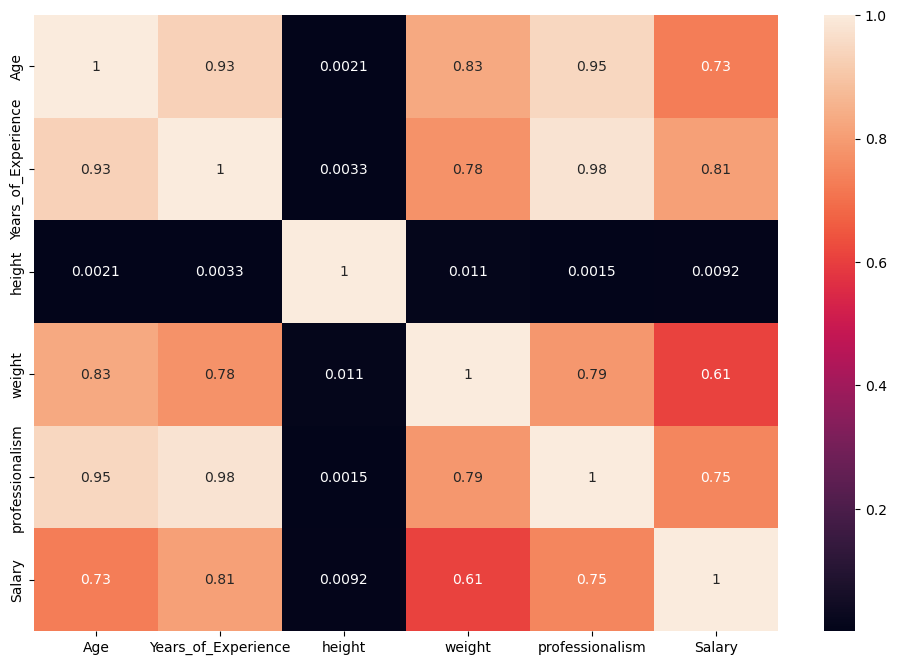

In [22]:
#use correlation to find the relationship between the variables
#use heatmap to visualize the correlation

cor = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(cor , annot= True)

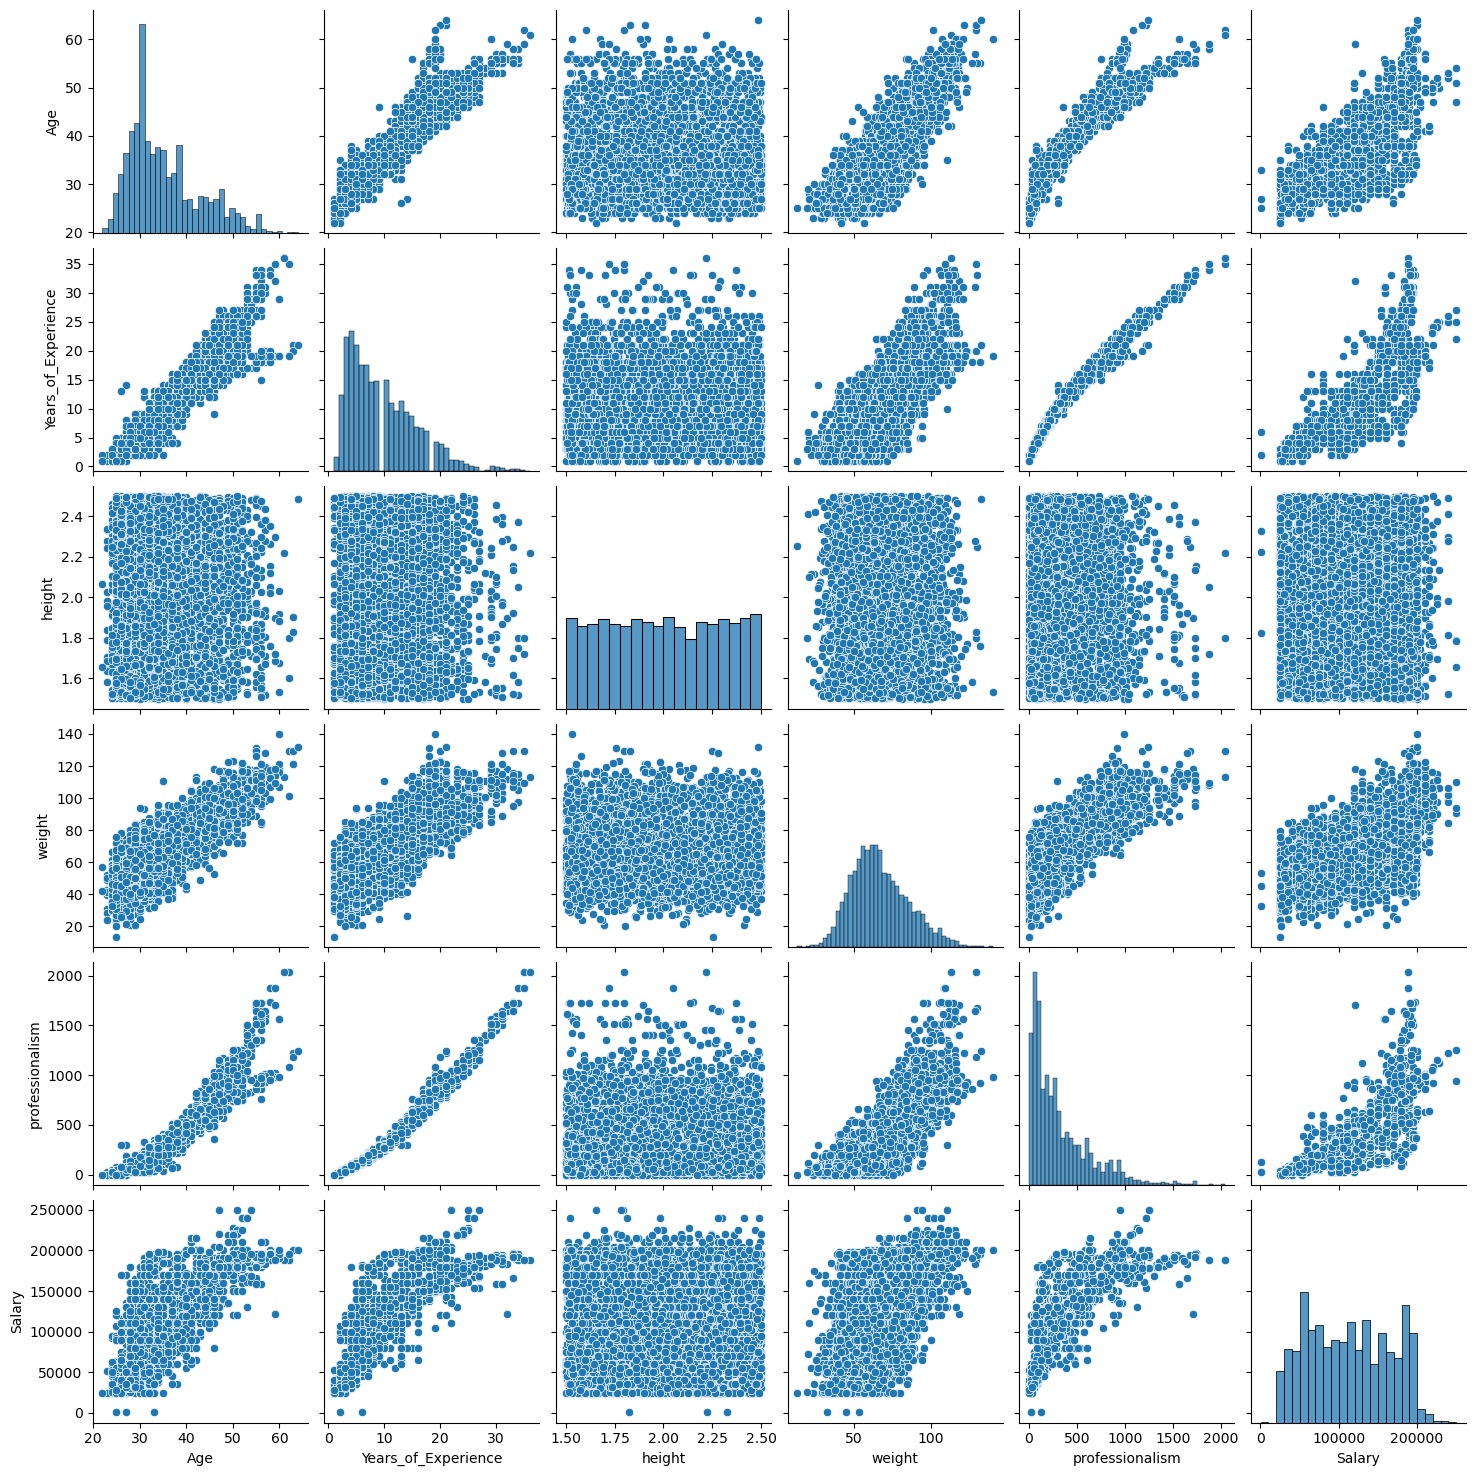

In [23]:
#use pairplot to see the relationship between the variables
sns.pairplot(data)

In [24]:
# check the sum od rows per gender
print(data.groupby('Gender').size())

# drop the gender O from the data
# data = data.loc[data['Gender']!='O']

Gender
F    2402
M    2941
O      12
dtype: int64


<Figure size 800x600 with 0 Axes>

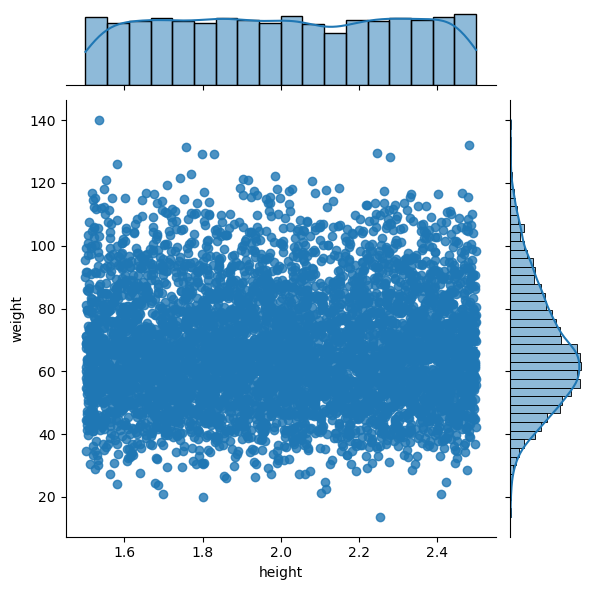

In [25]:
# use jointplot to display the relationship between height and weight

plt.figure(figsize=(8, 6))
sns.jointplot(x='height', y='weight', data=data, kind='reg')

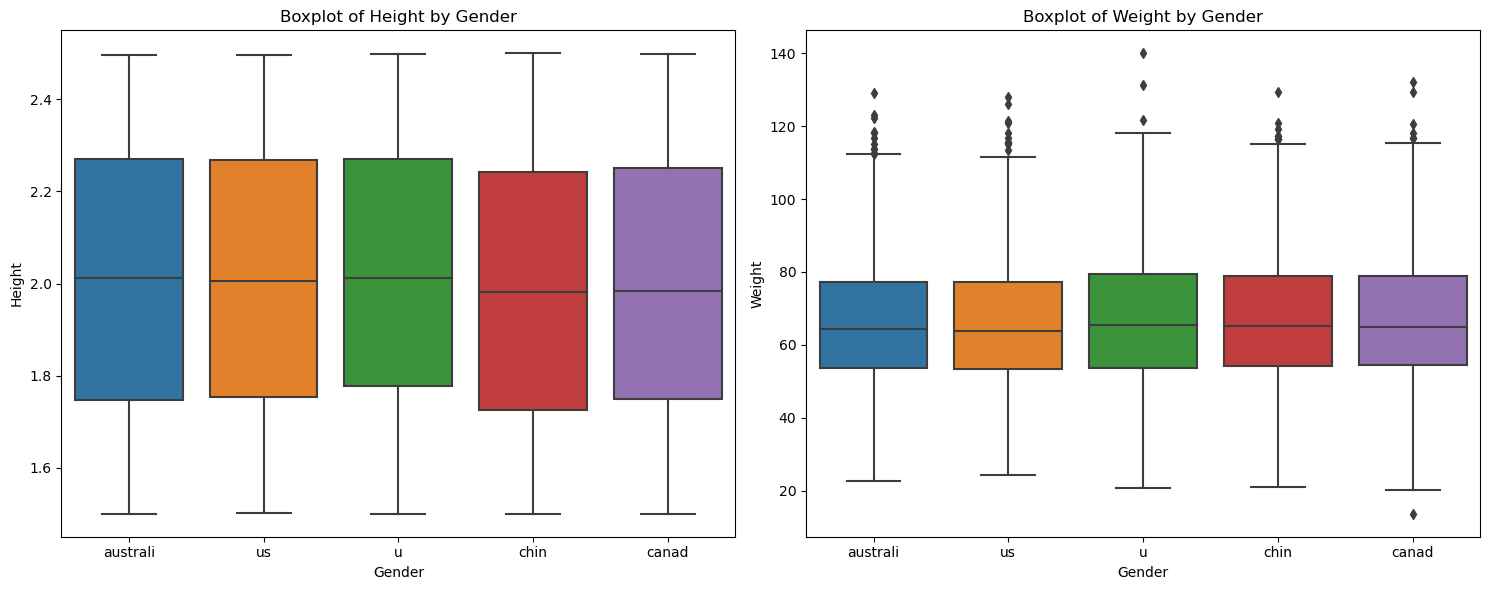

In [26]:
# Create two separate subplots for each box plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Create the first box plot for "height"
sns.boxplot(data=data, x="Country", y="height", ax=axes[0])
axes[0].set_title('Boxplot of Height by Gender')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Height')

# Create the second box plot for "weight"
sns.boxplot(data=data, x="Country", y="weight", ax=axes[1])
axes[1].set_title('Boxplot of Weight by Gender')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Weight')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

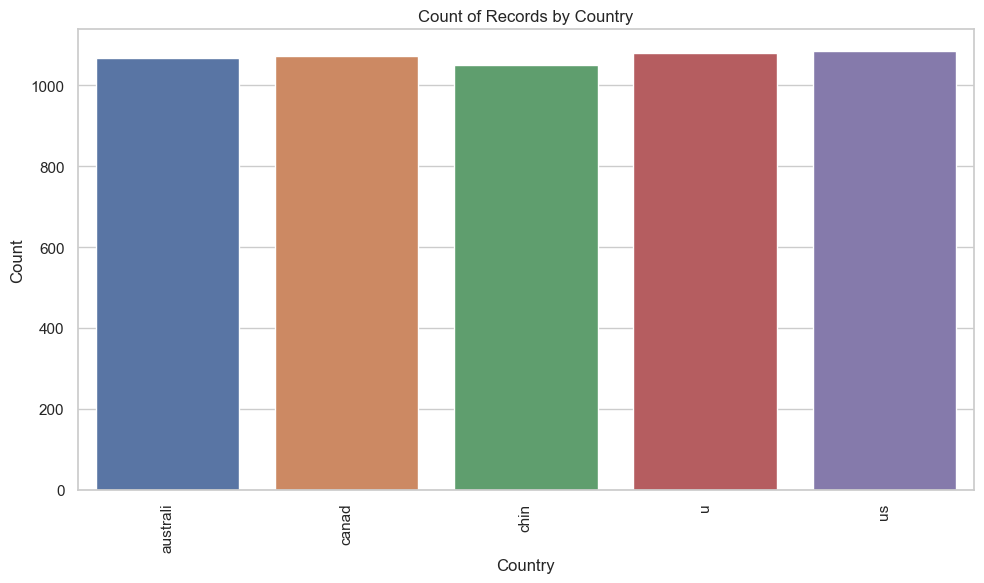

In [27]:
#use barplot to show the count of records by country 
country = data.groupby('Country').size().reset_index(name='Count')

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(data=country, x='Country', y='Count')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Count of Records by Country')
plt.tight_layout()

<Axes: xlabel='Education_Level', ylabel='Salary'>

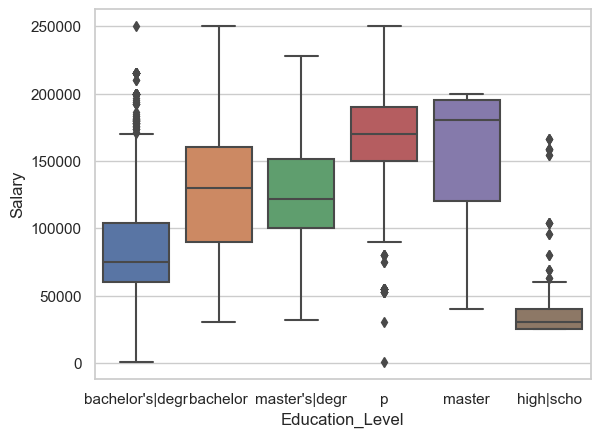

In [28]:
#use boxplot to see the relationship between education level and salary
sns.boxplot(x='Education_Level',y='Salary',data=data)

<Axes: xlabel='Gender', ylabel='Salary'>

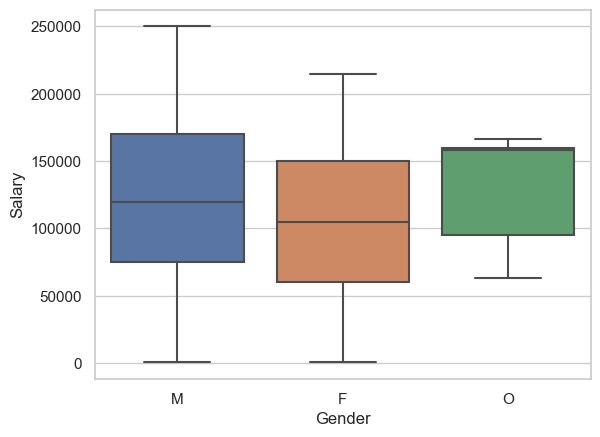

In [29]:
#use boxplot to see the distribution of salary
sns.boxplot(x='Gender',y='Salary',data=data)

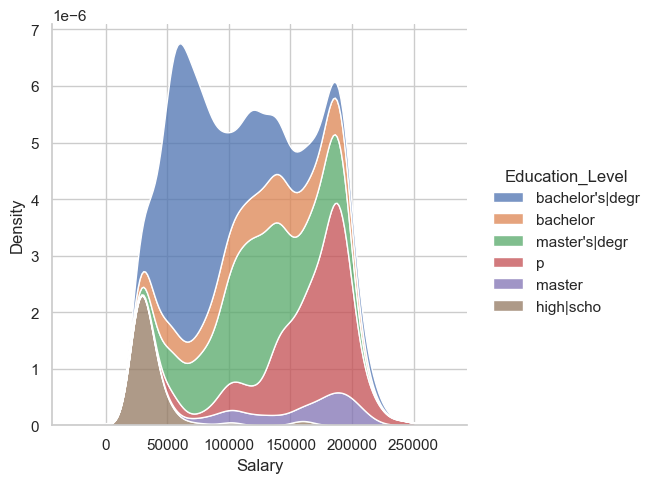

In [30]:
#use displot to plot the distribution of the salary for each education level
sns.displot(data=data, x="Salary", hue="Education_Level", multiple="stack",kind="kde")

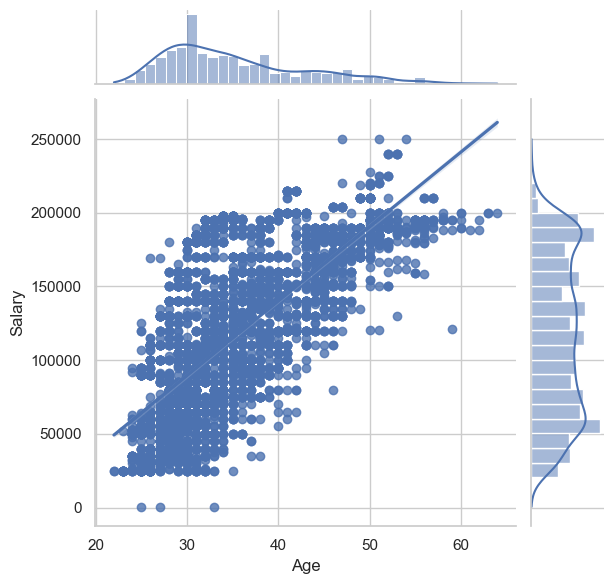

In [31]:
# sns.set(style="whitegrid")
sns.jointplot(x='Age', y='Salary', data=data, kind='reg')


In [32]:

# # Define bin edges
# age_bins = [20,50,80]

# # Create a new column 'AgeBin' with bin labels
# data['AgeBin'] = pd.cut(data['Age'], bins=age_bins, labels=['20-49','50-80'])

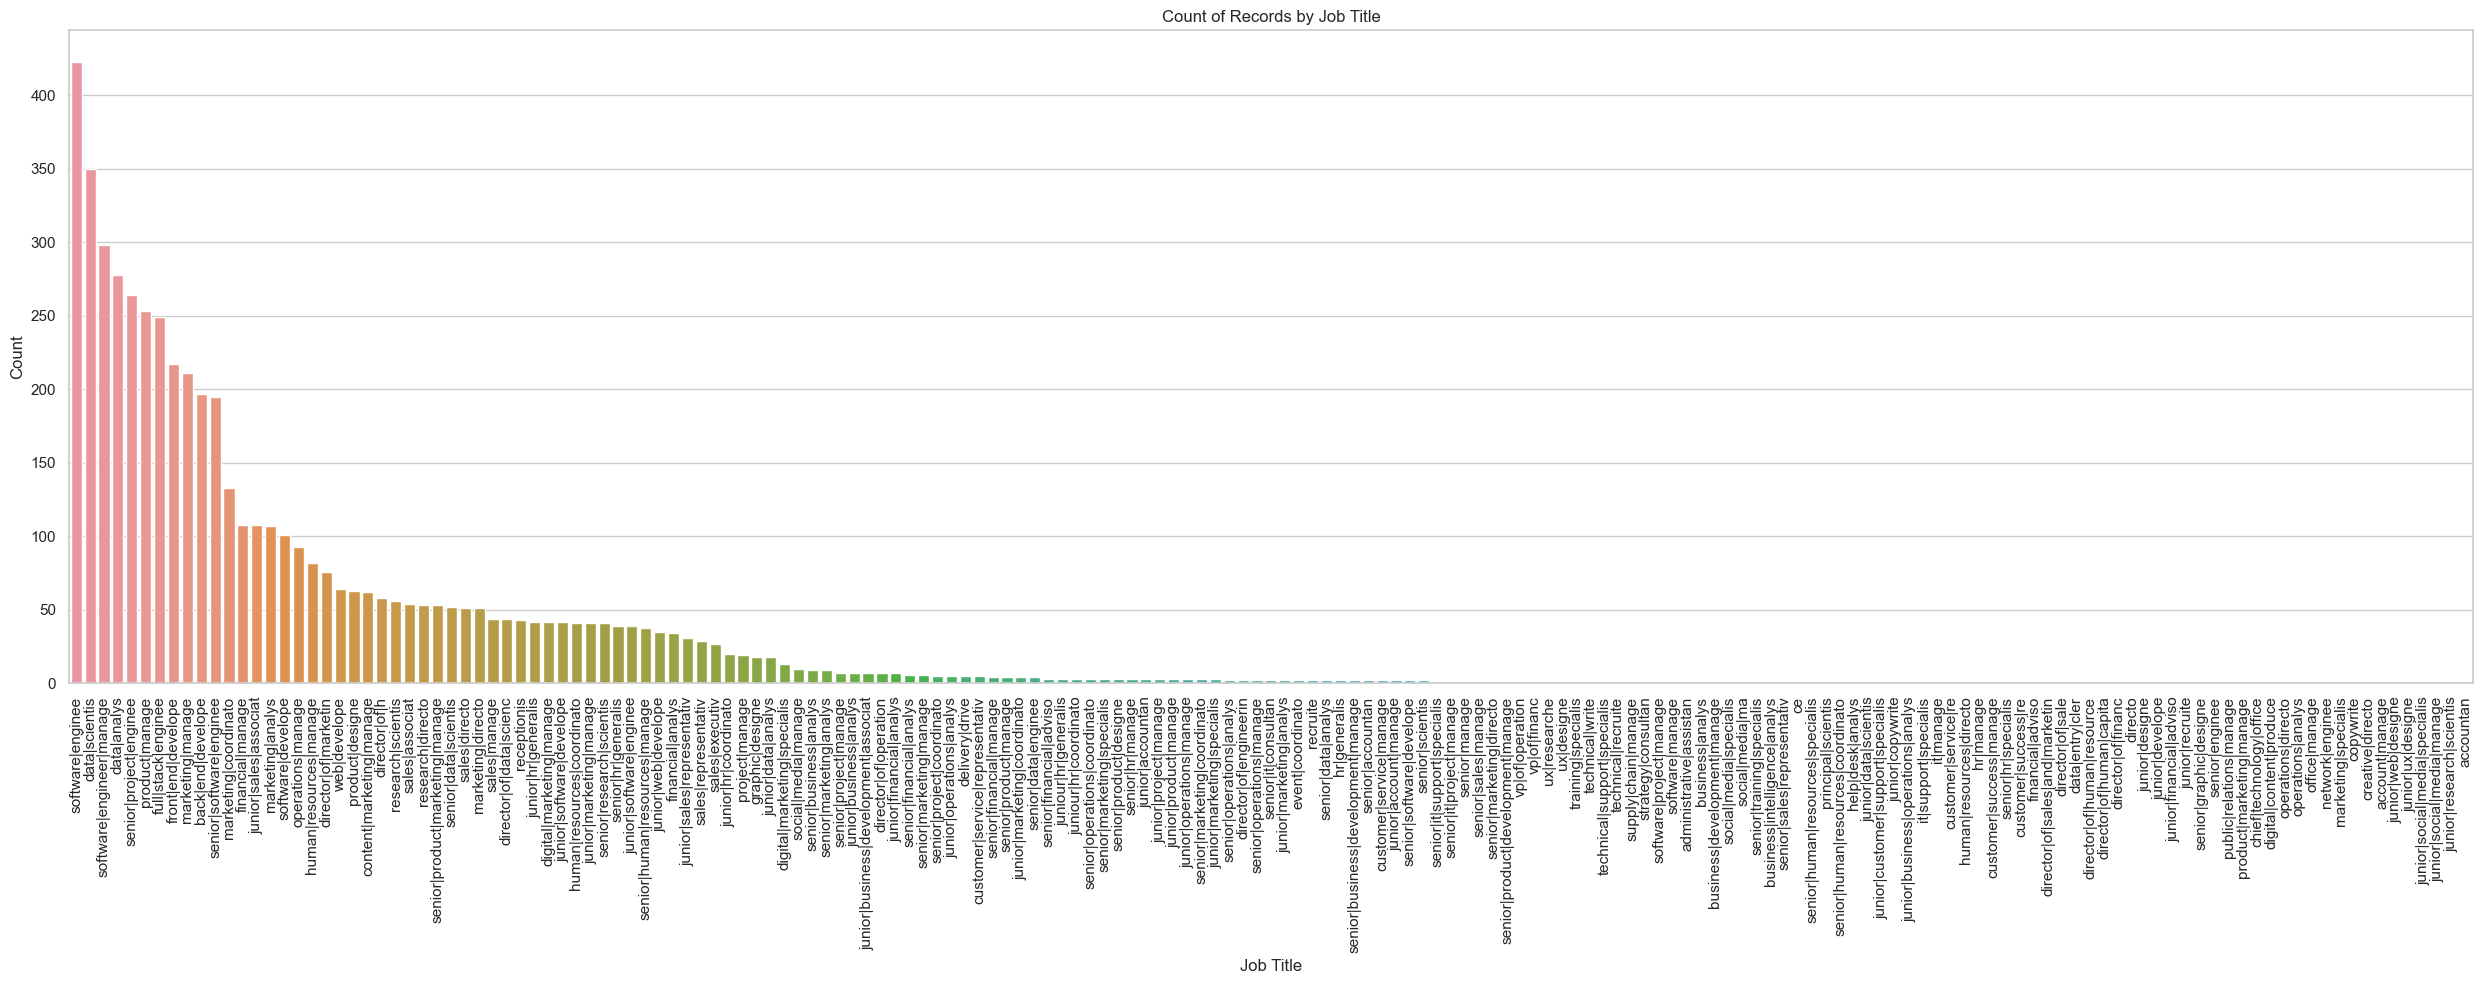

In [33]:
job = data.groupby('Job_Title').size().reset_index(name='count').sort_values(by='count' ,ascending=False)

sns.set(style="whitegrid")
plt.figure(figsize=(25, 10))
sns.barplot(data=job, x='Job_Title', y='count')
plt.xticks(rotation=90)
plt.xlabel('Job Title')
plt.ylabel('Count')
plt.title('Count of Records by Job Title')
plt.tight_layout()

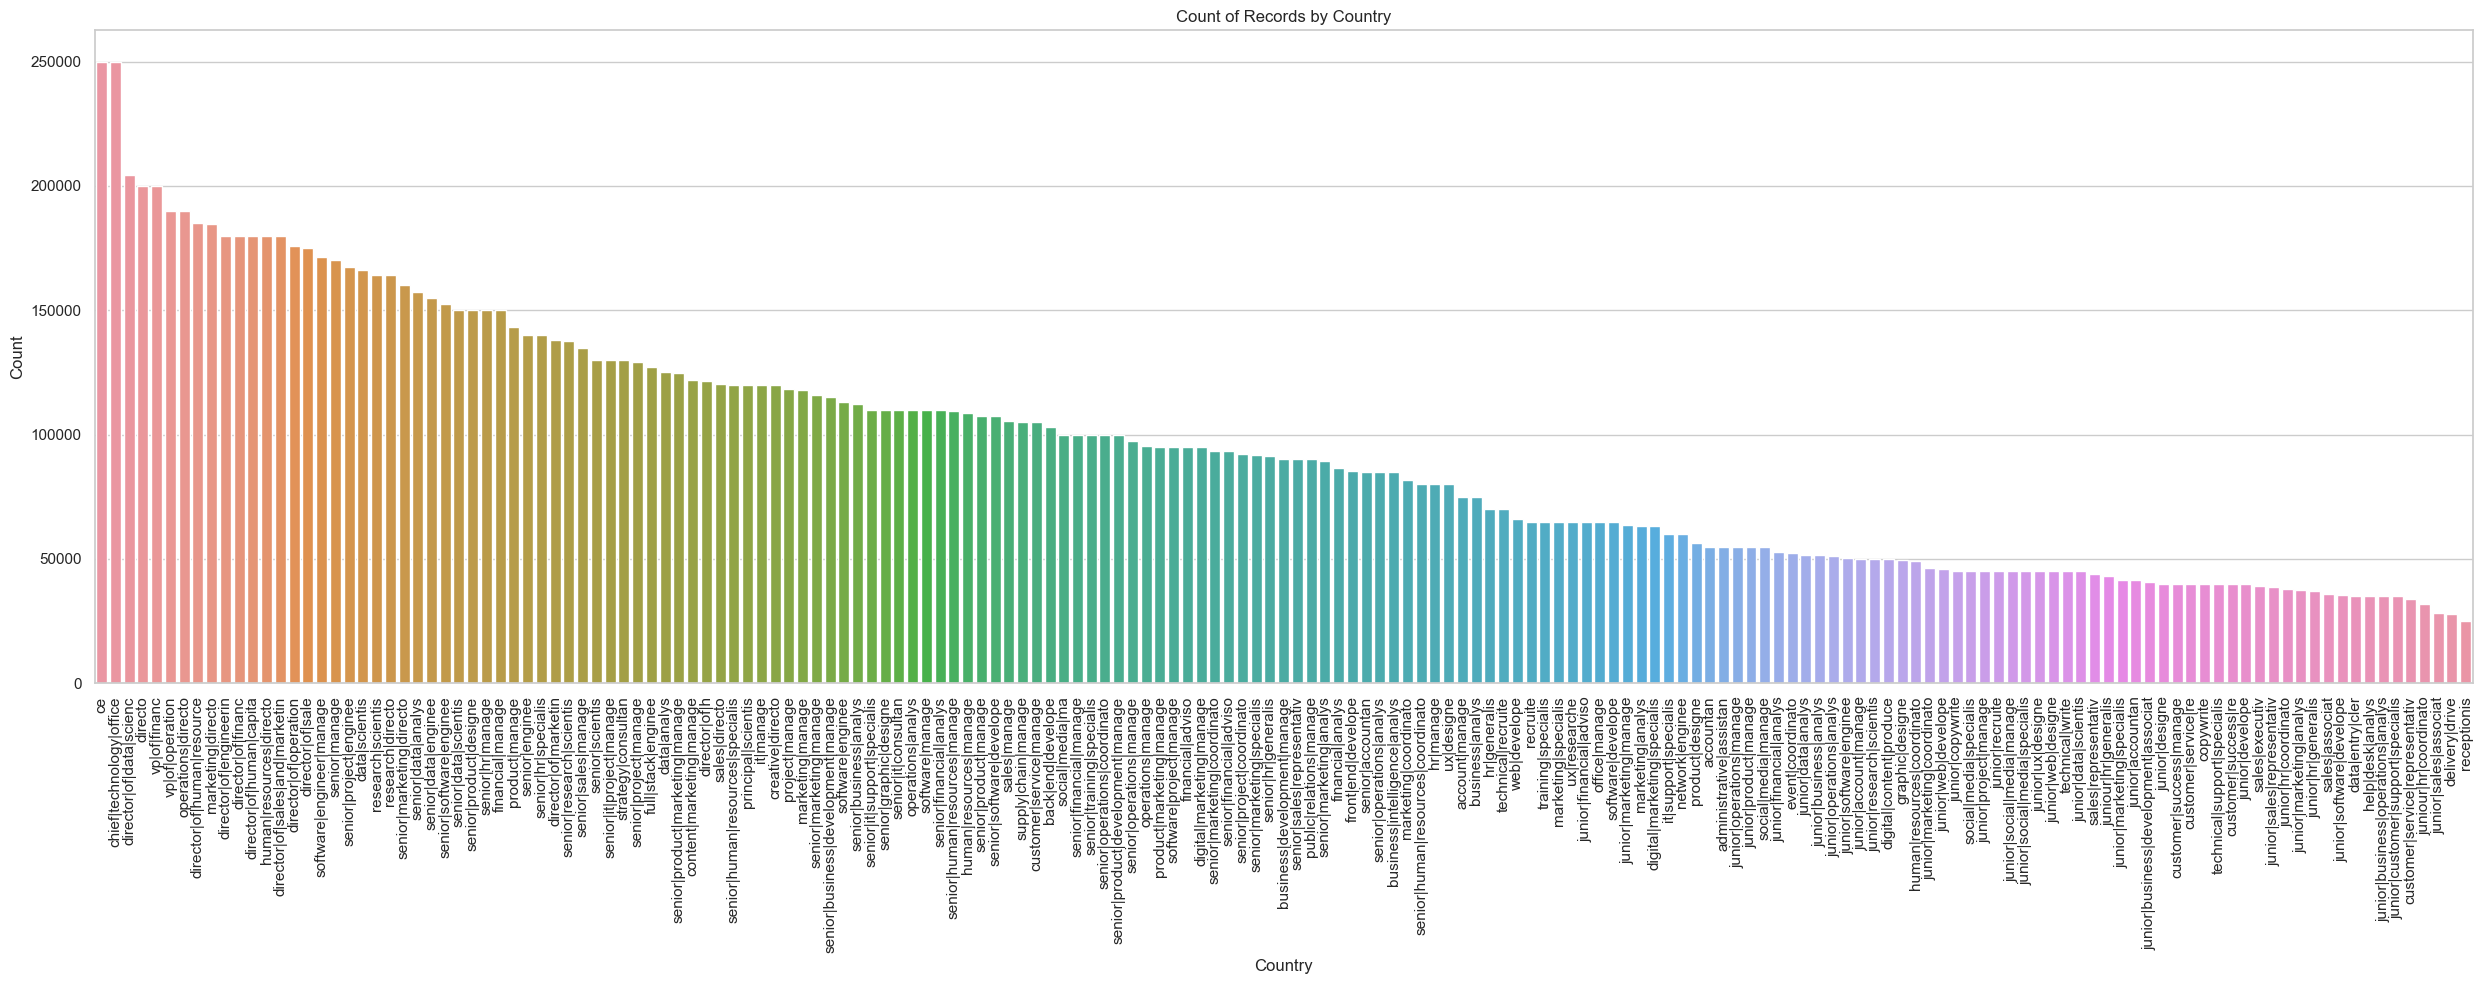

In [34]:
job = data.groupby('Job_Title')['Salary'].mean().reset_index(name='mean').sort_values(by='mean' ,ascending=False)

sns.set(style="whitegrid")
plt.figure(figsize=(25, 10))
sns.barplot(data=job, x='Job_Title', y='mean')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Count of Records by Country')
plt.tight_layout()

# **Feature Engineering**

In [35]:
def clean_similar_strings(column):
    similar_strings_mapping = {
        r"bachelor's\|degr": "bachelor",
        r"master's\|degr": "master",
        r"high\|scho": "high_school",

        
        # Add more patterns and replacements as needed
    }

    cleaned_values = []
    for value in column:
        if isinstance(value, str):  # Check if the value is a string
            for pattern, replacement in similar_strings_mapping.items():
                value = re.sub(pattern, replacement, value, flags=re.IGNORECASE)
        cleaned_values.append(value)

    return cleaned_values


data['Education_Level']= clean_similar_strings(data['Education_Level'])

data.Education_Level.unique()

array(['bachelor', 'master', 'p', 'high_school'], dtype=object)

### Pipline for the Train Data

In [36]:
class DataPipeline:
    def __init__(self, data):
        self.data = data
        self.label_encoders = {}
        self.count_encoders = {}
        self.k_means_models = {}
        self.target_encoders = {}
        self.median_mappings = {}
        self.ordinal_encoders = {}

    def transform_column_with_encoder(self, column_name):
        le = preprocessing.LabelEncoder()
        le.fit(self.data[column_name])
        transformed_column = le.transform(self.data[column_name])
        return transformed_column

    def add_encoded_data(self, column_name):
        transformed_data = self.transform_column_with_encoder(column_name)
        self.data['Transformed_' + column_name] = transformed_data

    def count_encode_column(self, column_name):
        encoder = CountFrequencyEncoder(encoding_method='count', variables=[column_name])
        encoder.fit(self.data)
        transformed_data = encoder.transform(self.data)

        transformed_column_name = column_name + '_frequency'
        self.data[transformed_column_name] = transformed_data[column_name]

    def k_means(self, column_name, num_clusters):
        num_clusters = num_clusters
        X = self.data[[column_name, 'Salary']]
        kmeans = KMeans(n_clusters=num_clusters)
        transformed_column_name = 'k_Means_' + column_name
        self.data[transformed_column_name] = kmeans.fit_predict(X)

    # def target_encode_categorical(self, categorical_col):
    #     category_means = self.data.groupby(categorical_col)['Salary'].mean()
    #     encoded_col = f'{categorical_col}_mean_target'
    #     self.data[encoded_col] = self.data[categorical_col].map(category_means)

    def target_encode_categorical(self, categorical_col, smoothing_factor=1):
        category_count = self.data.groupby(categorical_col).size()
        category_mean_salary = self.data.groupby(categorical_col)['Salary'].mean()
        
        encoded_col = f'{categorical_col}_mean_target'
        
        # Compute smoothed target encoding
        smoothed_target_encoding = (category_mean_salary * category_count + self.data['Salary'].mean() * smoothing_factor) / (category_count + smoothing_factor)
        
        self.data[encoded_col] = self.data[categorical_col].map(smoothed_target_encoding)    
        

    def compute_column_median(self, column_name):
        column_median = self.data.groupby(column_name)['Salary'].median().reset_index()
        transformed_column_name = column_name + '_median'
        self.data[transformed_column_name] = self.data[column_name].map(column_median.set_index(column_name)['Salary'])

    def ordinal_encode_column(self, column_name, ordered_categories):
        encoder = OrdinalEncoder(categories=[ordered_categories])
        transformed_data = encoder.fit_transform(self.data[[column_name]])
        self.data['Encoded_' + column_name] = transformed_data.flatten()    
  
    def run_pipeline(self):
        # Store the label encoder
        self.label_encoders['Job_Title'] = preprocessing.LabelEncoder()

        # Store the count encoder
        self.count_encoders['Job_Title'] = CountFrequencyEncoder(encoding_method='count', variables=['Job_Title'])

        # Store the KMeans model
        self.k_means_models['Age'] = KMeans(n_clusters=3)

        # Store the target encoder
        self.target_encoders['Job_Title'] = None  # Placeholder for now

        # Store the median mapping
        self.median_mappings['Education_Level'] = None  # Placeholder for now

        # Store the ordinal encoder
        self.ordinal_encoders['Education_Level'] = OrdinalEncoder(categories=[['high_school', "bachelor", "master", 'p']])

        # Fit and transform the label encoder
        self.label_encoders['Job_Title'].fit(self.data['Job_Title'])

        # Apply the transformations
        self.add_encoded_data('Job_Title')
        self.count_encode_column('Job_Title')
        self.k_means('Age', 3)
        self.target_encode_categorical('Job_Title')
        self.compute_column_median('Education_Level')
        self.ordinal_encode_column('Education_Level', ordered_categories=['high_school', "bachelor", "master", 'p'])


pipeline = DataPipeline(data)
pipeline.run_pipeline()

  File "c:\Users\saarl\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


In [37]:
# data = pd.get_dummies(data,columns=['Gender'])
# data = data[(data['Salary']<200000) & (data['Salary']>20000)]


In [38]:
# Split values in the 'Job_Title' column and convert to lowercase
data['Job_Title'] = data['Job_Title'].str.split('|').str.join(' ').str.lower()


# **Linear Regression Model**

### Linear regression pipeline using gridearch

In [41]:

# Define your features and target variable
# X = data[['Years_of_Experience','professionalism','Education_Level_median','Job_Title_frequency','Job_Title_mean_target','k_Means_Age']]
X = data[['Years_of_Experience', 'professionalism','Job_Title_frequency','Job_Title_mean_target']]
y = data.Salary

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the pipeline: pipeline
lnr_pipe = Pipeline([
    ('ssc', StandardScaler()),
    ('lnr', LinearRegression())
])

# Create a parameter grid for GridSearchCV for Linear Regression
lnr_params = {
    'lnr__fit_intercept': [True, False]
}

# Instantiate the GridSearchCV object for Linear Regression
gs_lnr = GridSearchCV(lnr_pipe, param_grid=lnr_params, scoring='neg_mean_squared_error', cv=5)

# Fit the GridSearchCV for Linear Regression to the training data
gs_lnr.fit(X_train, y_train)

# Get the best parameters and best RMSE for Linear Regression
best_lnr_params = gs_lnr.best_params_
best_lnr_rmse = np.sqrt(-gs_lnr.best_score_)

# Print the best parameters and lowest RMSE for Linear Regression
print("Best Linear Regression parameters found: ", best_lnr_params)
print("Best Linear Regression RMSE found: ", best_lnr_rmse)

# Calculate and print the test RMSE for Linear Regression
lnr_test_predictions = gs_lnr.predict(X_test)
lnr_test_rmse = np.sqrt(mean_squared_error(y_test, lnr_test_predictions))
print("Test RMSE for Linear Regression: ", lnr_test_rmse)

# Predict y_train for Linear Regression
lnr_train_predictions = gs_lnr.predict(X_train)
lnr_train_rmse = np.sqrt(mean_squared_error(y_train, lnr_train_predictions))
print("Train RMSE for Linear Regression: ", lnr_train_rmse)

# Create the pipeline: lasso_pipe
lasso_pipe = Pipeline([
    ('ssc', StandardScaler()),
    ('lasso', Lasso())
])

# Create a parameter grid for GridSearchCV for Lasso Regression
lasso_params = {
    'lasso__alpha': [0.01, 0.1, 1.0, 10.0]
}

# Create a parameter grid for GridSearchCV for Lasso Regression
gs_lasso = GridSearchCV(lasso_pipe, param_grid=lasso_params, scoring='neg_mean_squared_error', cv=5)

# Fit the GridSearchCV for Lasso Regression to the training data
gs_lasso.fit(X_train, y_train)

# Get the best parameters and best RMSE for Lasso Regression
best_lasso_params = gs_lasso.best_params_
best_lasso_rmse = np.sqrt(-gs_lasso.best_score_)

# Print the best parameters and lowest RMSE for Lasso Regression
print("Best Lasso Regression parameters found: ", best_lasso_params)
print("Best Lasso Regression RMSE found: ", best_lasso_rmse)

# Calculate and print the test RMSE for Lasso Regression
lasso_test_predictions = gs_lasso.predict(X_test)
lasso_test_rmse = np.sqrt(mean_squared_error(y_test, lasso_test_predictions))
print("Test RMSE for Lasso Regression: ", lasso_test_rmse)

# Predict y_train for Lasso Regression
lasso_train_predictions = gs_lasso.predict(X_train)
lasso_train_rmse = np.sqrt(mean_squared_error(y_train, lasso_train_predictions))
print("Train RMSE for Lasso Regression: ", lasso_train_rmse)

Best Linear Regression parameters found:  {'lnr__fit_intercept': True}
Best Linear Regression RMSE found:  22097.352191140835
Test RMSE for Linear Regression:  22570.570999259195
Train RMSE for Linear Regression:  22080.804550194574
Best Lasso Regression parameters found:  {'lasso__alpha': 0.01}
Best Lasso Regression RMSE found:  22097.35223492518
Test RMSE for Lasso Regression:  22570.576587270705
Train RMSE for Lasso Regression:  22080.804550444616


In [42]:
X_test['y'] = y_test
X_test['Predicted'] = lasso_test_predictions
X_test['Residual'] = abs(y_test - lasso_test_predictions)/y_test
X_test[X_test['Residual'] > 0.3]


,Years_of_Experience,professionalism,Job_Title_frequency,Job_Title_mean_target,y,Predicted,Residual
id,,,,,,,
3261,6.0,120.0,423,113225.569069,80000.0,113458.804005,0.418235
2772,7.0,150.0,423,113225.569069,90000.0,120547.502773,0.339417
1239,3.0,23.0,249,127187.353141,55000.0,88098.156663,0.601785
2735,10.0,272.0,278,125084.735789,100000.0,134320.351554,0.343204
3214,5.0,112.0,423,113225.569069,75000.0,103939.528000,0.385860
...,...,...,...,...,...,...,...
4181,7.0,150.0,423,113225.569069,75000.0,120547.502773,0.607300
5224,2.0,25.0,39,51966.032129,55000.0,31078.355611,0.434939
2342,3.0,50.0,423,113225.569069,60000.0,89983.092029,0.499718


<Figure size 640x480 with 0 Axes>

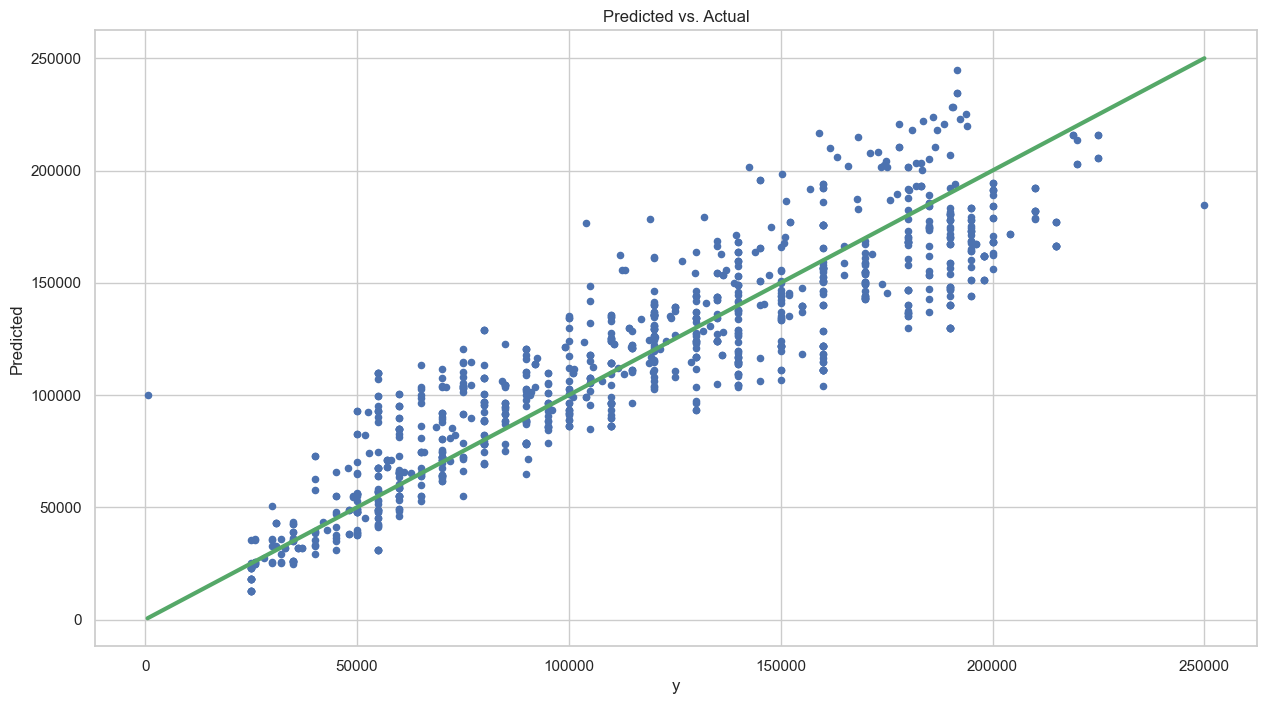

In [43]:
plt.figure()
amin, amax = min(X_test['y']), max(X_test['y'])
ax = X_test.plot('y', 'Predicted', kind='scatter',
                #        c=colors, 
                    #  xlim=[amin, amax], ylim=[amin, amax],
                     title='Predicted vs. Actual',
                     figsize = (15,8))
ax.plot(np.linspace(amin, amax, 2), np.linspace(amin, amax, 2),
        linewidth=3, color='g')                    

Text(0.5, 1.0, 'Residuals')

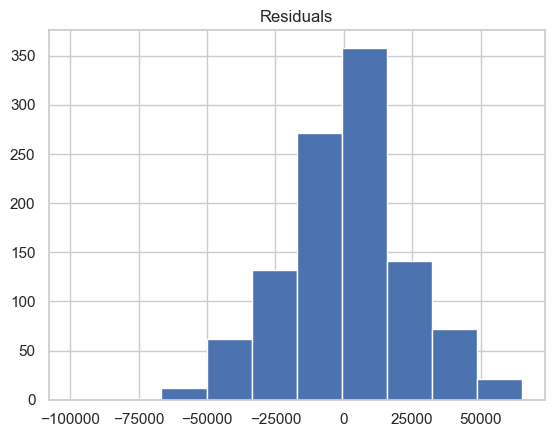

In [44]:
plt.hist(X_test['y']-X_test['Predicted'])
plt.title('Residuals')

# **KNN Model**

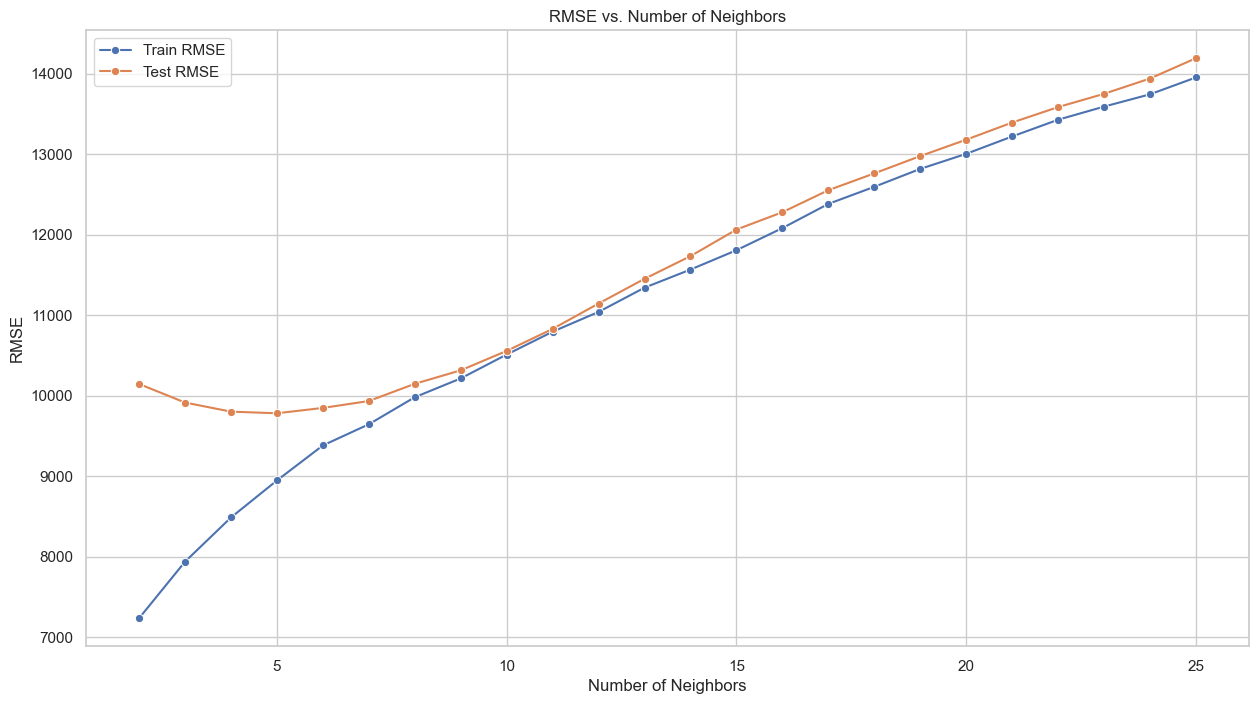

In [64]:


# Define features and target
# X = data[['Years_of_Experience','professionalism','Education_Level_median','Job_Title_frequency','Job_Title_mean_target','k_Means_Age']]
X = data[['Years_of_Experience', 'professionalism','Job_Title_frequency','Job_Title_mean_target']]
y = data.Salary

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

n_neighbors= []
rmse_train_l = []
rmse_test_l = []

for i in range(2,26):

    # Create a KNeighborsRegressor model
    model = KNeighborsRegressor(n_neighbors=i)  # You can adjust the number of neighbors

    # Train the model on the training data
    model.fit(X_train_scaled, y_train)

    # Make predictions on the train data
    y_pred_train = model.predict(X_train_scaled)

    # Make predictions on the test data
    y_pred_test = model.predict(X_test_scaled)

    # Calculate RMSE
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

    n_neighbors.append(i) 
    rmse_train_l.append(rmse_train)
    rmse_test_l.append(rmse_test)

    # You can add the predicted salaries back to the DataFrame if needed
    # data['Predicted_Salary_knn'] = y_pred

    # Print the DataFrame with predicted salaries and RMSE

    # print("Root Mean Squared Error:", rmse)
   

plt.figure(figsize=(15, 8))
sns.lineplot(x=n_neighbors, y=rmse_train_l, marker='o', label='Train RMSE')
sns.lineplot(x=n_neighbors, y=rmse_test_l, marker='o', label='Test RMSE')
# plt.scatter(n_neighbors[np.argmin(rmse_test)], min(rmse_test), color='r', label=f'Min Test RMSE: {min(rmse_test):.2f}')
plt.title('RMSE vs. Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.show()

In [65]:
    model = KNeighborsRegressor(n_neighbors=4)  
    # Train the model on the training data
    model.fit(X_train_scaled, y_train)

    # Make predictions on the train data
    y_pred_train = model.predict(X_train_scaled)

    # Make predictions on the test data
    y_pred_test = model.predict(X_test_scaled)

    # Calculate RMSE
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

    print(f'RMSE for train data: {rmse_train}')
    print(f'RMSE for test data: {rmse_test}')

RMSE for train data: 8485.799395515027
RMSE for test data: 9800.215385794327


In [66]:
X_test['y'] = y_test
X_test['Predicted'] = y_pred_test
X_test['Residual'] = abs(y_test - y_pred_test)/y_test
X_test[X_test['Residual'] > 0.3]

,Years_of_Experience,professionalism,Job_Title_frequency,Job_Title_mean_target,y,Predicted,Residual
id,,,,,,,
1239,3.0,23.0,249,127187.353141,55000.0,80016.00,0.454836
445,5.0,116.0,423,113225.569069,140000.0,90250.00,0.355357
6014,7.0,150.0,253,143022.209784,85000.0,127500.00,0.500000
71,13.0,429.0,2,81880.428385,70000.0,108750.00,0.553571
2654,2.0,23.0,298,171257.024365,579.0,93209.25,159.983161
6335,2.0,24.0,42,95363.750818,30000.0,47500.00,0.583333
388,6.0,116.0,423,113225.569069,140000.0,70250.00,0.498214
1183,5.0,112.0,423,113225.569069,160000.0,96250.00,0.398438
135,12.0,390.0,1,85320.642577,55000.0,100000.00,0.818182


<Figure size 640x480 with 0 Axes>

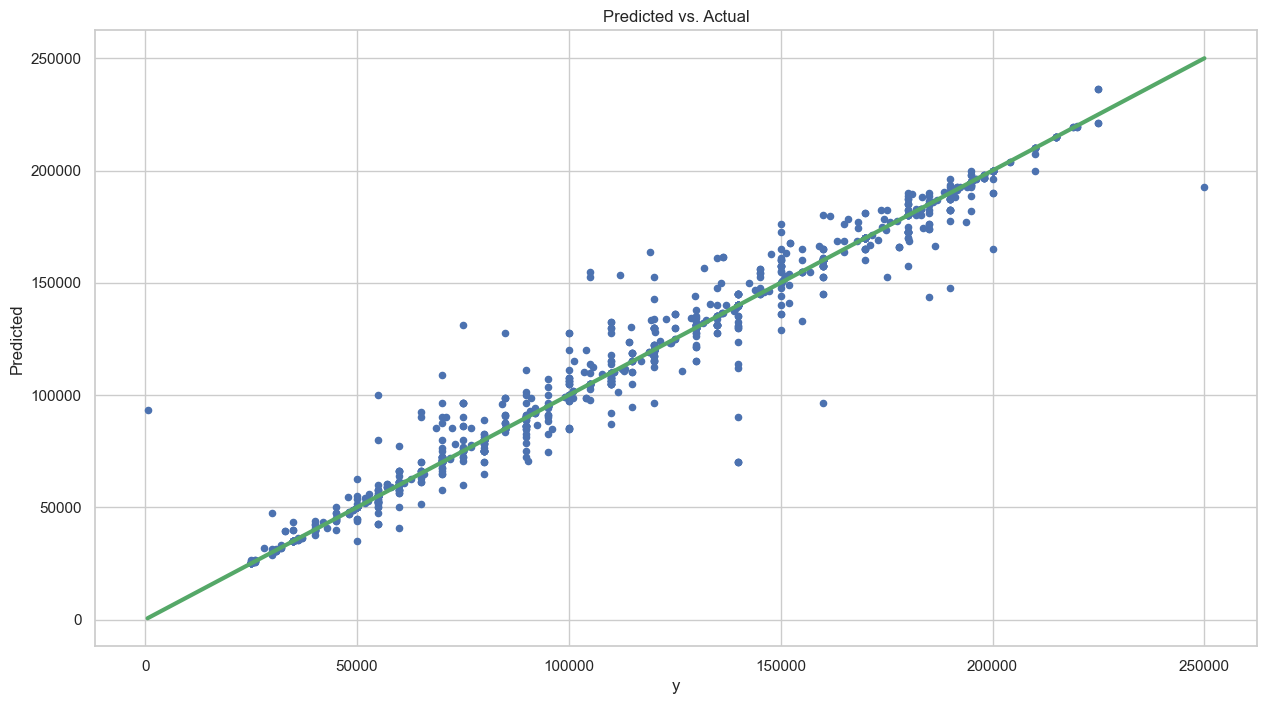

In [67]:
plt.figure()
amin, amax = min(X_test['y']), max(X_test['y'])
ax = X_test.plot('y', 'Predicted', kind='scatter',
                #        c=colors, 
                    #  xlim=[amin, amax], ylim=[amin, amax],
                     title='Predicted vs. Actual',
                     figsize = (15,8))
ax.plot(np.linspace(amin, amax, 2), np.linspace(amin, amax, 2),
        linewidth=3, color='g')        

Text(0.5, 1.0, 'Residuals')

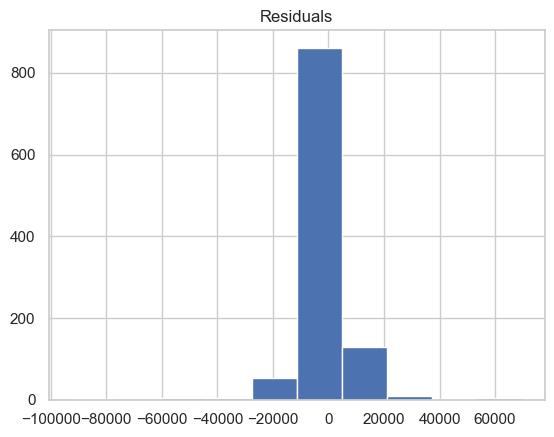

In [68]:
plt.hist(X_test['y']-X_test['Predicted'])
plt.title('Residuals')

<Axes: xlabel='Age', ylabel='Salary'>

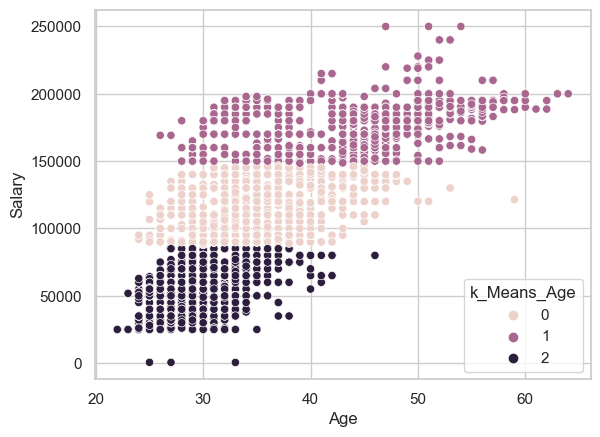

In [69]:
sns.scatterplot(x='Age', y='Salary', data=data, hue='k_Means_Age')

### **Decision Tree Regressor Model**

Train Root Mean Squared Error: 15476.533704713656
Test Root Mean Squared Error: 16277.166387533334


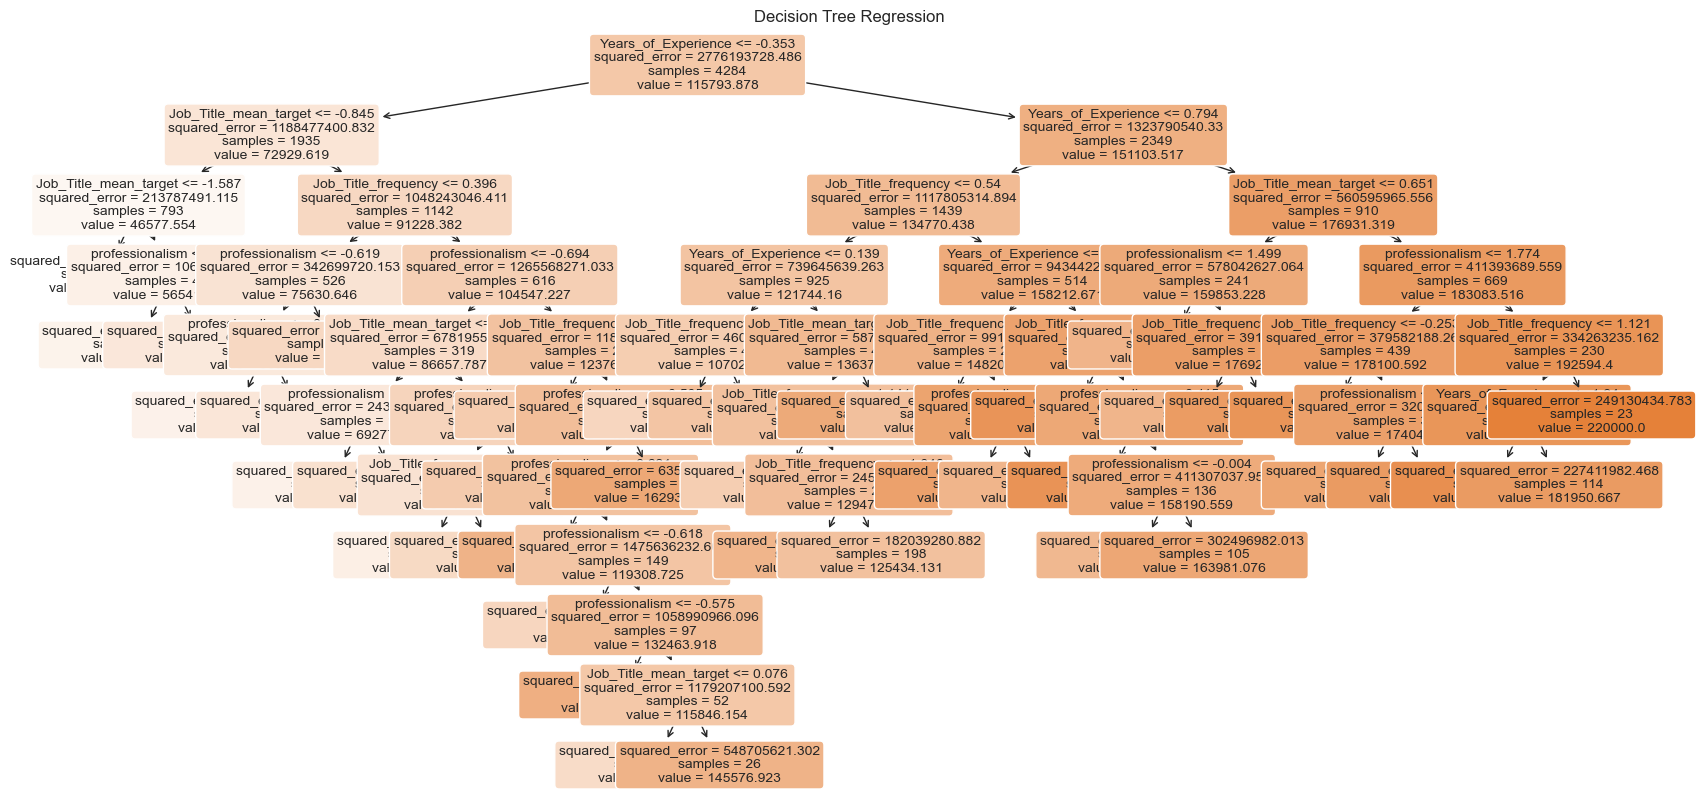

In [51]:


# Assuming you have loaded your data into the 'data' DataFrame

# Define features and target
# X = data[['Years_of_Experience', 'professionalism', 'Education_Level_median','Job_Title_frequency', 'Transformed_Job_Title', 'k_Means_Age','Encoded_Education_Level']]
X = data[['Years_of_Experience', 'professionalism','Job_Title_frequency','Job_Title_mean_target']]
y = data.Salary

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a DecisionTreeRegressor model
model = DecisionTreeRegressor(max_leaf_nodes=40)  

# Train the model on the entire data
model.fit(X_train_scaled, y_train)

# Make predictions on the train data
y_pred_train = model.predict(X_train_scaled)

# Make predictions on the test data
y_pred_test = model.predict(X_test_scaled)

# Calculate RMSE
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

# You can add the predicted salaries back to the DataFrame if needed
# data['Predicted_Salary'] = y_pred

# Print the RMSE
print("Train Root Mean Squared Error:", rmse_train)
print("Test Root Mean Squared Error:", rmse_test)

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X_test.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree Regression')
plt.show()
# data

In [52]:
feature_importances = model.feature_importances_

# Print feature names and their importances
for feature_name, importance in zip(X_test.columns, feature_importances):
    print(f"Feature: {feature_name},    Importance: {importance}")

Feature: Years_of_Experience,    Importance: 0.7137093610344535
Feature: professionalism,    Importance: 0.06436467594919103
Feature: Job_Title_frequency,    Importance: 0.09757362812365807
Feature: Job_Title_mean_target,    Importance: 0.12435233489269744


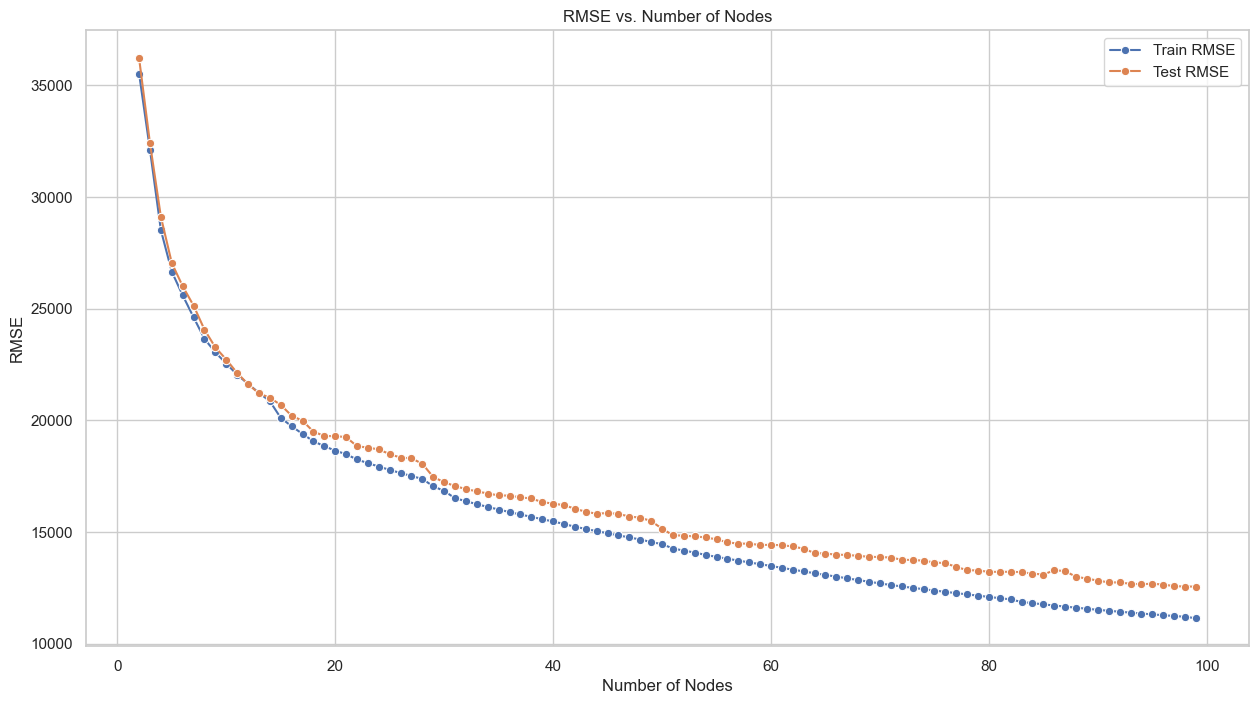

In [53]:
max_leaf_nodes= []
rmse_train_l = []
rmse_test_l = []

for i in range(2, 100):
    # Create a DecisionTreeRegressor model with varying max_leaf_nodes
    model = DecisionTreeRegressor(max_leaf_nodes=i)

    # Train the model on the training data
    model.fit(X_train_scaled, y_train)

    # Make predictions on the train data
    y_pred_train = model.predict(X_train_scaled)

    # Make predictions on the test data
    y_pred_test = model.predict(X_test_scaled)

    # Calculate RMSE for training and test sets
    rmse_train_i = mean_squared_error(y_train, y_pred_train, squared=False)
    rmse_test_i = mean_squared_error(y_test, y_pred_test, squared=False)

    max_leaf_nodes.append(i)
    rmse_train_l.append(rmse_train_i)
    rmse_test_l.append(rmse_test_i)

plt.figure(figsize=(15, 8))
sns.lineplot(x=max_leaf_nodes, y=rmse_train_l, marker='o', label='Train RMSE')
sns.lineplot(x=max_leaf_nodes, y=rmse_test_l, marker='o', label='Test RMSE')
plt.title('RMSE vs. Number of Nodes')
plt.xlabel('Number of Nodes')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.show()

In [54]:
X_test['y'] = y_test
X_test['Predicted'] = y_pred_test
X_test['Residual'] = abs(y_test - y_pred_test)/y_test
X_test[X_test['Residual'] > 0.3]

,Years_of_Experience,professionalism,Job_Title_frequency,Job_Title_mean_target,y,Predicted,Residual
id,,,,,,,
169,10.0,306.0,195,152220.618802,105000.0,142039.344828,0.352756
6589,6.0,112.0,42,95363.750818,55000.0,80533.526786,0.464246
2451,11.0,288.0,298,171257.024365,104661.0,138577.516129,0.324061
945,4.0,81.0,350,165890.715912,180000.0,72698.500000,0.596119
3851,5.0,116.0,423,113225.569069,65000.0,97522.727273,0.500350
6486,3.0,52.0,42,95363.750818,40000.0,54264.753086,0.356619
4559,8.0,231.0,42,39084.681050,65000.0,86226.890756,0.326568
3086,6.0,112.0,264,166986.208623,82944.0,108991.166667,0.314033
6409,3.0,52.0,44,105680.917448,40000.0,54264.753086,0.356619


<Figure size 640x480 with 0 Axes>

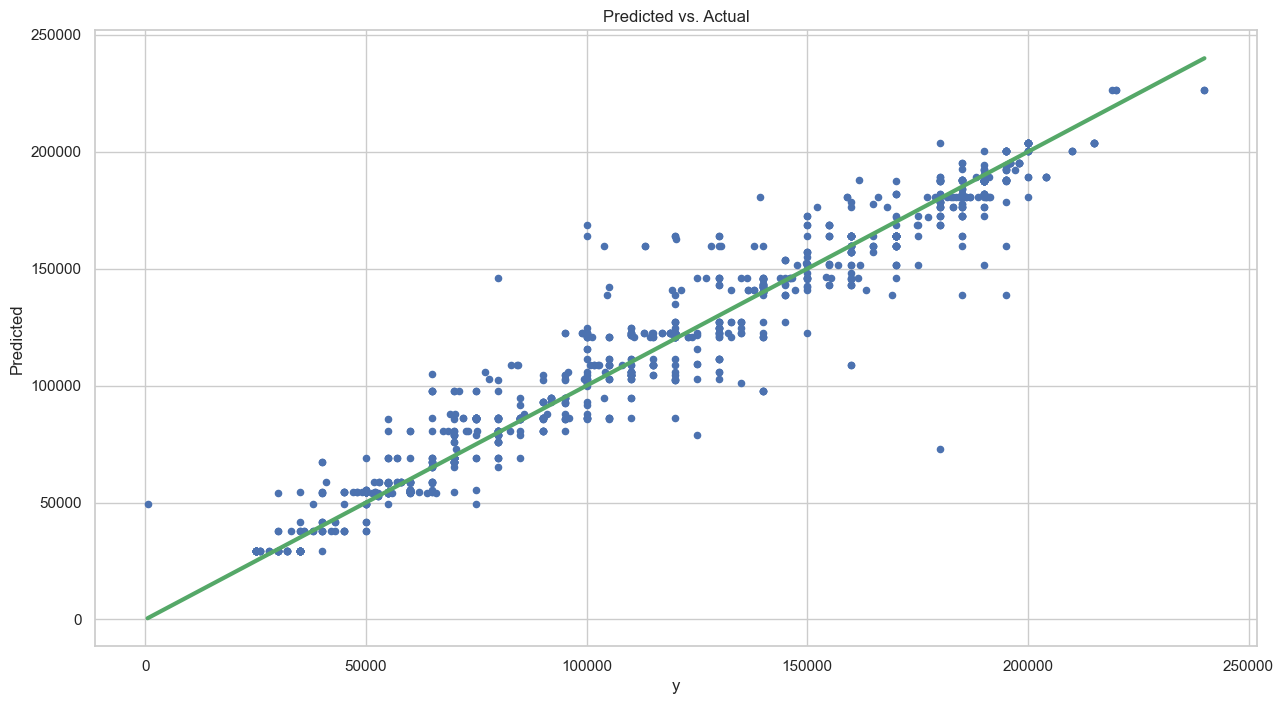

In [55]:
plt.figure()
amin, amax = min(X_test['y']), max(X_test['y'])
ax = X_test.plot('y', 'Predicted', kind='scatter',
                #        c=colors, 
                    #  xlim=[amin, amax], ylim=[amin, amax],
                     title='Predicted vs. Actual',
                     figsize = (15,8))
ax.plot(np.linspace(amin, amax, 2), np.linspace(amin, amax, 2),
        linewidth=3, color='g')     

# Combined Models

In [56]:
X = data[['Years_of_Experience', 'professionalism','Job_Title_frequency','Job_Title_mean_target']]
y = data.Salary

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Initialize and train multiple models

models = [LinearRegression(), DecisionTreeRegressor(max_leaf_nodes=40),KNeighborsRegressor(n_neighbors=4)]
for model in models:
    model.fit(X_train_scaled, y_train)

predictions_train = [model.predict(X_train_scaled) for model in models]    

# Make predictions with each model
predictions = [model.predict(X_test_scaled) for model in models]

# Calculate the mean predictions between models
mean_predictions_train = sum(predictions_train) / len(models)

# Calculate the mean predictions between models
mean_predictions = sum(predictions) / len(models)


# Evaluate mean predictions of the train data using RMSE
mean_rmse_train = mean_squared_error(y_train, mean_predictions_train, squared=False)
print(f"Mean Predictions of tarin (Ensemble Mean): RMSE = {mean_rmse_train}")

# Evaluate mean predictions using RMSE
mean_rmse = mean_squared_error(y_test, mean_predictions, squared=False)
print(f"Mean Predictions (Ensemble Mean): RMSE = {mean_rmse}")

Mean Predictions of tarin (Ensemble Mean): RMSE = 12506.018428343456
Mean Predictions (Ensemble Mean): RMSE = 13083.54330510725


In [57]:
X_test['y'] = y_test
X_test['Predicted'] = mean_predictions
X_test['Residual'] = abs(y_test - mean_predictions)/y_test
X_test[X_test['Residual'] > 0.3]

,Years_of_Experience,professionalism,Job_Title_frequency,Job_Title_mean_target,y,Predicted,Residual
id,,,,,,,
1239,3.0,23.0,249,127187.353141,55000.0,77166.881443,0.403034
6438,10.0,256.0,76,137800.536171,80000.0,106703.641193,0.333796
6474,5.0,108.0,211,117771.892855,55000.0,76496.133351,0.390839
445,5.0,116.0,423,113225.569069,140000.0,94465.244235,0.325248
6451,4.0,52.0,44,105680.917448,40000.0,54949.104336,0.373728
6543,10.0,256.0,76,137800.536171,80000.0,106703.641193,0.333796
6014,7.0,150.0,253,143022.209784,85000.0,135064.448312,0.588994
6423,4.0,52.0,44,105680.917448,40000.0,54949.104336,0.373728
2395,13.0,330.0,264,166986.208623,103947.0,153114.607755,0.473007


<Figure size 640x480 with 0 Axes>

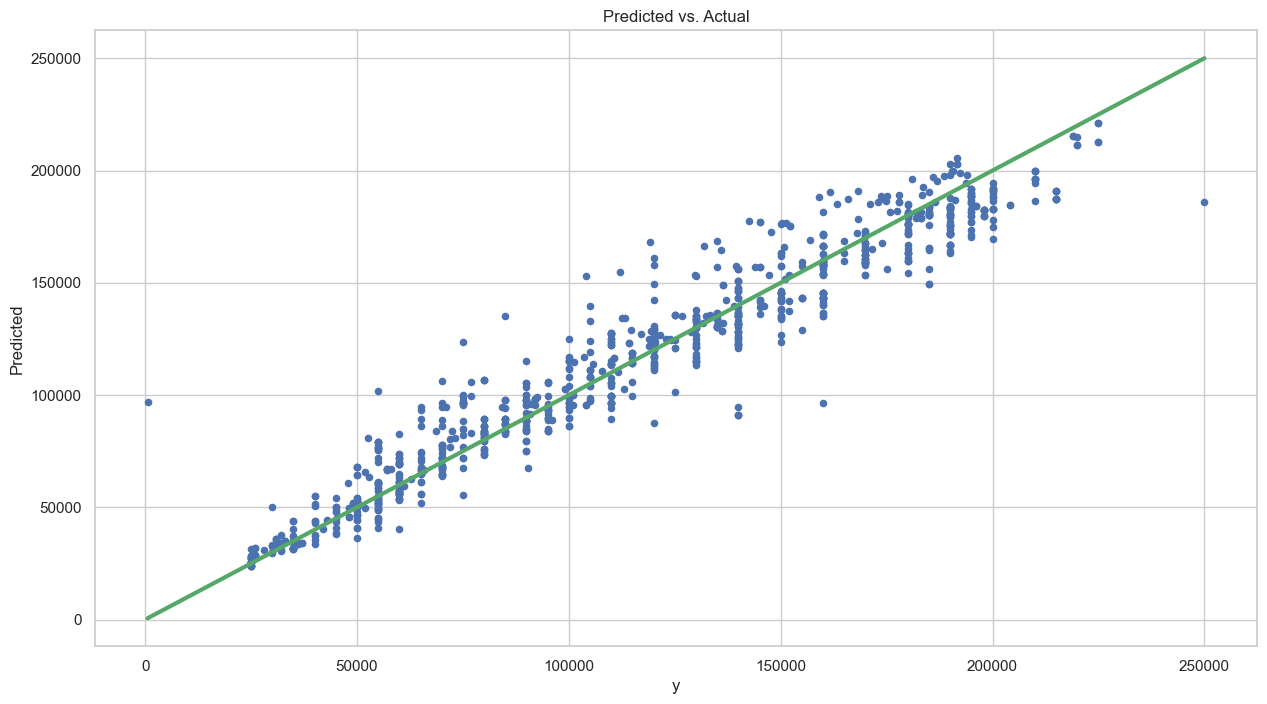

In [58]:
plt.figure()
amin, amax = min(X_test['y']), max(X_test['y'])
ax = X_test.plot('y', 'Predicted', kind='scatter',
                #        c=colors, 
                    #  xlim=[amin, amax], ylim=[amin, amax],
                     title='Predicted vs. Actual',
                     figsize = (15,8))
ax.plot(np.linspace(amin, amax, 2), np.linspace(amin, amax, 2),
        linewidth=3, color='g')    

# Predict the X test Data

In [59]:
def clean_similar_strings(column):
    similar_strings_mapping = {
        r"bachelor's\|degr": "bachelor",
        r"master's\|degr": "master",
        r"high\|scho": "high_school",

        
        # Add more patterns and replacements as needed
    }

    cleaned_values = []
    for value in column:
        if isinstance(value, str):  # Check if the value is a string
            for pattern, replacement in similar_strings_mapping.items():
                value = re.sub(pattern, replacement, value, flags=re.IGNORECASE)
        cleaned_values.append(value)

    return cleaned_values


modified_X['Education_Level']= clean_similar_strings(modified_X['Education_Level'])

modified_X.Education_Level.unique()

array(['master', 'bachelor', 'high_school', 'p'], dtype=object)

### Pipeline for the Test Data 

In [60]:
class TestDataPipeline:
    def __init__(self, test_data, train_pipeline):
        self.test_data = test_data
        self.train_pipeline = train_pipeline  # This is the instance of the training data pipeline

    def transform_column_with_encoder(self, column_name, encoder):
        transformed_column = self.test_data[column_name].apply(lambda x: x if x in encoder.classes_ else 'data|analys')
        transformed_column = encoder.transform(transformed_column)
        return transformed_column

    def add_encoded_data(self, column_name, encoder):
        transformed_data = self.transform_column_with_encoder(column_name, encoder)
    
        # Find unseen categories and assign a new integer label for them
        unseen_mask = ~np.isin(self.test_data[column_name], encoder.classes_)
        num_unseen = np.sum(unseen_mask)
        if num_unseen > 0:
            unseen_labels = np.arange(len(encoder.classes_), len(encoder.classes_) + num_unseen)
            transformed_data[unseen_mask] = unseen_labels
    
        self.test_data['Transformed_' + column_name] = transformed_data

    def count_encode_column(self, column_name, encoder):
        frequency_column_name = column_name + '_frequency'
    
        # Create a dictionary mapping categories to frequency values during training
        category_to_frequency = self.train_pipeline.data.set_index(column_name)[frequency_column_name].to_dict()
    
        # Use the dictionary to map frequency values in the test data
        transformed_column = self.test_data[column_name].map(category_to_frequency)
        transformed_column_name = column_name + '_frequency'
        self.test_data[transformed_column_name] = transformed_column.fillna(0)  # Fill NaN with a default value if necessary

    def k_means(self, column_name, num_clusters, kmeans_model):
        transformed_column_name = 'k_Means_' + column_name
        train_transformed_column = self.train_pipeline.data[transformed_column_name]
    
        nearest_age_value = train_transformed_column.iloc[(train_transformed_column - self.test_data[column_name]).abs().idxmin()]
    
        self.test_data[transformed_column_name] = nearest_age_value


    def target_encode_categorical(self, categorical_col, encoder):
        encoded_col = f'{categorical_col}_mean_target'
    
        # Map only the categories seen during training, handle unseen categories
        self.test_data[encoded_col] = self.test_data[categorical_col].map(lambda x: encoder.get(x, encoder['mean_target']))
  

    # def compute_column_median(self, column_name, median_mapping):
    #     transformed_column_name = column_name + '_median'
    #     self.test_data[transformed_column_name] = self.test_data[column_name].map(median_mapping).fillna(self.train_pipeline.data[column_name].median())

    def ordinal_encode_column(self, column_name, ordered_categories):
        ordinal_mapping = {category: index for index, category in enumerate(ordered_categories)}
        transformed_data = self.test_data[column_name].map(ordinal_mapping)
        transformed_column_name = 'Encoded_' + column_name
        self.test_data[transformed_column_name] = transformed_data

    def run_test_pipeline(self):
        # Apply the transformations from the training pipeline
        label_encoder = self.train_pipeline.label_encoders['Job_Title']
        count_encoder =self.train_pipeline.count_encoders['Job_Title']
        k_means_model = self.train_pipeline.k_means_models['Age']
        target_encoder = self.train_pipeline.target_encoders['Job_Title']
        target_encoded_dict = self.train_pipeline.data.groupby('Job_Title')['Job_Title_mean_target'].mean().to_dict()
        target_encoded_dict['mean_target'] = self.train_pipeline.data['Job_Title_mean_target'].mean()
        target_encoder = {'default_mean': self.train_pipeline.data['Job_Title_mean_target'].mean(), **target_encoded_dict}
        # median_mapping = self.train_pipeline.median_mappings['Education_Level']
        ordinal_encoder = self.train_pipeline.ordinal_encoders['Education_Level']
        ordered_categories = ['high_school', 'bachelor', 'master', 'p']


        self.add_encoded_data('Job_Title', label_encoder)
        self.count_encode_column('Job_Title', count_encoder)
        self.k_means('Age', 3, k_means_model)
        self.target_encode_categorical('Job_Title', target_encoder)
        # self.compute_column_median('Education_Level', median_mapping)
        self.ordinal_encode_column('Education_Level', ordered_categories)


# Assuming you have 'test_data' as your test dataset
test_pipeline = TestDataPipeline(modified_X, pipeline)
test_pipeline.run_test_pipeline()

In [61]:
modified_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341 entries, 0 to 1340
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1341 non-null   int64  
 1   Id1                      1341 non-null   int64  
 2   Id2                      1341 non-null   int64  
 3   Age                      1341 non-null   float64
 4   Gender                   1341 non-null   object 
 5   Education_Level          1341 non-null   object 
 6   Job_Title                1341 non-null   object 
 7   Years_of_Experience      1341 non-null   float64
 8   Country                  1341 non-null   object 
 9   Race                     1341 non-null   object 
 10  height                   1341 non-null   float64
 11  weight                   1341 non-null   float64
 12  professionalism          1341 non-null   float64
 13  Transformed_Job_Title    1341 non-null   int32  
 14  Job_Title_frequency     

### Run the model

In [62]:
X_test_pred= modified_X[['Years_of_Experience', 'professionalism','Job_Title_frequency','Job_Title_mean_target']]
X_train = data[['Years_of_Experience', 'professionalism','Job_Title_frequency','Job_Title_mean_target']]
y_train = data.Salary
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test_pred)


model = KNeighborsRegressor(n_neighbors=5)  
# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the train data
y_pred_train = model.predict(X_train_scaled)

# Make predictions on the test data
y_pred_test = model.predict(X_test_scaled)

# Calculate RMSE
# rmse_train = mean_squared_error(data, y_pred_train, squared=False)
# rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

# print(f'RMSE for train data: {rmse_train}')
# print(f'RMSE for test data: {rmse_test}')
modified_X['y'] = y_pred_test
modified_X.sort_values(by='y', ascending=True).tail(10)

ids = modified_X ['id'].tolist()
id_salary =  dict(zip(ids, y_pred_test))

In [63]:
print(id_salary)

{6480: 132000.0, 5343: 64000.0, 2576: 70000.0, 6103: 122000.0, 3290: 93000.0, 2797: 148000.0, 6577: 70000.0, 4401: 39000.0, 693: 101000.0, 4700: 100000.0, 666: 40000.0, 694: 98000.0, 6329: 124000.0, 4129: 39000.0, 1083: 64000.0, 1606: 154000.0, 5977: 134000.0, 1231: 148000.0, 4239: 39000.0, 127: 139000.0, 5606: 64000.0, 6386: 139000.0, 5990: 122000.0, 5439: 101000.0, 850: 39000.0, 2891: 102000.0, 5483: 40000.0, 1329: 118000.0, 1763: 64000.0, 3332: 40000.0, 668: 100000.0, 2591: 118000.0, 2485: 100000.0, 2484: 107000.0, 1218: 102000.0, 1125: 122000.0, 5327: 70000.0, 5165: 25000.0, 2425: 136000.0, 4175: 113000.0, 3094: 101000.0, 400: 100000.0, 112: 148000.0, 6056: 102000.0, 1905: 118000.0, 5328: 70000.0, 2379: 98000.0, 3496: 64000.0, 912: 40000.0, 4103: 40000.0, 105: 142000.0, 241: 40000.0, 2042: 102000.0, 1043: 64000.0, 2418: 119000.0, 6110: 118000.0, 533: 70000.0, 1815: 101000.0, 2705: 70000.0, 6624: 40000.0, 5132: 100000.0, 6043: 114000.0, 1170: 64000.0, 5802: 122000.0, 5372: 115000.0,

In [70]:
#save the predictions to a json file

import json

# Specify the output JSON file path
output_json_file = "id_salary.json"

# Save the dictionary to the JSON file
with open(output_json_file, 'w') as json_file:
    json.dump(id_salary, json_file)

print(f"Data has been saved to '{output_json_file}'.")



Data has been saved to 'id_salary.json'.
